#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

#from bvcopula import SingleParamCopulaBase
from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GaussianCopula_Flow_Likelihood
from bvcopula import FrankCopula, FrankCopula_Likelihood
from bvcopula import ClaytonCopula, ClaytonCopula_Likelihood
from bvcopula import GumbelCopula, GumbelCopula_Likelihood
from bvcopula import StudentTCopula, StudentTCopula_Likelihood
from bvcopula import MixtureCopula, MixtureCopula_Likelihood
from bvcopula import GPInferenceModel, KISS_GPInferenceModel
from bvcopula import Mixed_GPInferenceModel, GridInterpolationVariationalStrategy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST263'
day_name = 'Day1'
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

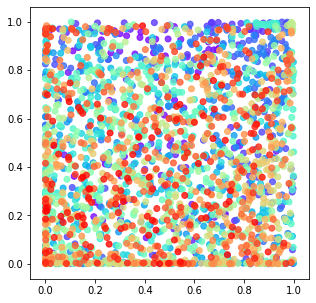

In [3]:
signals = signal_pkl['signals_transformed']
n1 = 13
n2 = 17
Y_all = np.array([signals[n1],signals[n2]]).T
#Y_all = np.array([signals[n1],behaviour_pkl['transformed_licks']]).T
X_all = np.array(behaviour_pkl['position'])#local_time

rule = (Y_all[:,0]>1e-4) & (Y_all[:,1]>1e-4)  \
        & (Y_all[:,0]<1.-1e-4) & (Y_all[:,1]<1.-1e-4)#\
        #& (X_all > 120.)#& (time>7*60)
 
X = np.reshape(X_all[rule],(-1,1))
X[X<0] = 160.+X[X<0]
X[X>160] = X[X>160]-160.
X = X/160.
Y = Y_all[rule]

NSamp = X.shape[0]
plt.figure(figsize=(5,5))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 3
plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)

# X = np.flip(X,axis=0).copy()
# Y = np.flip(Y,axis=0).copy()

In [4]:
#likelihoods = [ClaytonCopula_Likelihood(rotation='0°'),ClaytonCopula_Likelihood(rotation='180°'),GaussianCopula_Likelihood()]
likelihoods = [ClaytonCopula_Likelihood(rotation='0°'),
               ClaytonCopula_Likelihood(rotation='90°'),
              ClaytonCopula_Likelihood(rotation='180°'),
              ClaytonCopula_Likelihood(rotation='270°'),
              ]

#likelihoods = [FrankCopula_Likelihood()]

# likelihoods = [GaussianCopula_Likelihood(),
#              FrankCopula_Likelihood()]

# likelihoods = [GumbelCopula_Likelihood(rotation='0°'),
#                GumbelCopula_Likelihood(rotation='90°'),
#               GumbelCopula_Likelihood(rotation='180°'),
#               GumbelCopula_Likelihood(rotation='270°')]

In [5]:
NSamp

6898

In [6]:
Y[Y!=Y]

array([], dtype=float64)

In [7]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float().cuda(device=0)
train_y = torch.tensor(Y).float().cuda(device=0)

In [24]:
# define the model (optionally on GPU)
grid_size = 128#train_x.shape[0]
thetas_sharing = None#torch.tensor([0,1,2,1])
if thetas_sharing is not None:
    num_fs = len(likelihoods)+thetas_sharing.max().numpy() # indep_thetas + num_copulas - 1
else:
    num_fs = 2*len(likelihoods)-1
model = Mixed_GPInferenceModel(MixtureCopula_Likelihood(likelihoods, theta_sharing=thetas_sharing), 
                               num_fs,  
                               prior_rbf_length=0.2, grid_size=grid_size).cuda(device=0)

In [25]:
# train the model

base_lr = 1e-3
iter_print = 100

print('Basic lr for most of parameters: {}'.format(base_lr))

#torch.autograd.set_detect_anomaly(True)

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.mean_module.parameters()},
    {'params': model.variational_strategy.variational_distribution.chol_variational_covar},
    {'params': model.covar_module.raw_outputscale},
    {'params': model.variational_strategy.variational_distribution.variational_mean, 'lr': .1},
    {'params': model.covar_module.base_kernel.raw_lengthscale, 'lr': .01} #, 'lr': 0.001
], lr=base_lr)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll  = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=True)
#mllv = gpytorch.mlls.VariationalELBO(model.likelihood, model, num_data=train_y.size(0), combine_terms=False)

losses, rbf, means = [], [], []

def train(train_x, train_y, num_iter=2000):
    model.train()

    p = 0.
    nans = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        
#         if i==0:
#             prior_mean = model.variational_strategy.variational_distribution.variational_mean.data
#             prior_mean[2][96:112] = 0.5*torch.ones_like(prior_mean[2][96:112])
#             #prior_mean[1] = 0.0*torch.ones_like(prior_mean[0])
#             model.variational_strategy.variational_distribution.variational_mean.data = prior_mean
            
        loss = -mll(output, train_y)  
        #log_lik, kl_div, log_prior = mllv(output, train_y)
        if len(losses)>100: 
            p += np.abs(np.mean(losses[-50:]) - np.mean(losses[-100:-50]))
        losses.append(loss.detach().cpu().numpy())
        rbf.append(model.covar_module.base_kernel.lengthscale.detach().cpu().numpy())
        means.append(model.variational_strategy.variational_distribution.variational_mean.detach().cpu().numpy())
        if not (i + 1) % iter_print:
            
            mean_p = p/100
            #loss_scale = np.abs(loss.detach().cpu().numpy() - np.mean(losses))
            
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {}, dLoss: {:.3}, mean f: {:.3}, dmean: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().squeeze(), 
                mean_p, np.mean(means[-1]), 
                np.mean(np.abs(means[-100]-means[-1]))
            ))
            #print("{:.3}, {:.3}, {:.3}".format(log_lik, kl_div, log_prior))

            #print(np.std(losses[-100:]))
            if (0 < mean_p < 0.0001):# & (np.mean(np.abs(1-means[-100]/means[-1])) < 0.05): 
                print("Converged!")
                break
            p = 0.

        # The actual optimization step
        loss.backward()
        covar_grad = model.variational_strategy.variational_distribution.chol_variational_covar.grad
#         # strict
#         assert torch.all(covar_grad==covar_grad)
        #light
        if torch.any(covar_grad!=covar_grad):
            for n, par in model.named_parameters():
                grad = par.grad.data
                if torch.nonzero(grad!=grad).shape[0]!=0:
                    print('NaN grad in {}'.format(n))
                nans+=torch.nonzero(grad!=grad).shape[0]
                if torch.any(grad.abs()==float('inf')):
                    print("Grad inf... fixing...")
                    grad = torch.clamp(grad,-1.,1.)
                grad[grad!=grad] = 0.0
                par.grad.data = grad
        optimizer.step()
        
%time train(train_x,train_y)

Basic lr for most of parameters: 0.001
Iter 100/2000 - Loss: 0.0809   lengthscale: [0.15587999 0.18970829 0.16941877 0.15559162 0.14000283 0.18506365
 0.16803432], dLoss: 0.0, mean f: -1.04, dmean: 1.27
Iter 200/2000 - Loss: 0.0102   lengthscale: [0.17351188 0.21212903 0.21951306 0.1582321  0.14965439 0.1602248
 0.13386437], dLoss: 0.0859, mean f: -1.57, dmean: 0.708
Iter 300/2000 - Loss: -0.00752   lengthscale: [0.18933544 0.24104737 0.24476409 0.17896836 0.15460184 0.14148618
 0.11714744], dLoss: 0.0184, mean f: -1.82, dmean: 0.37
Iter 400/2000 - Loss: -0.0149   lengthscale: [0.20589644 0.27453578 0.27191517 0.2071629  0.1504865  0.12567317
 0.10844832], dLoss: 0.00562, mean f: -1.96, dmean: 0.214
Iter 500/2000 - Loss: -0.0187   lengthscale: [0.22861867 0.30645567 0.30995375 0.23408905 0.14259422 0.11179994
 0.10341416], dLoss: 0.00259, mean f: -2.04, dmean: 0.142
Iter 600/2000 - Loss: -0.0214   lengthscale: [0.25381973 0.33960095 0.37192473 0.26182288 0.1322436  0.09987599
 0.100200

(2000, 7, 128)


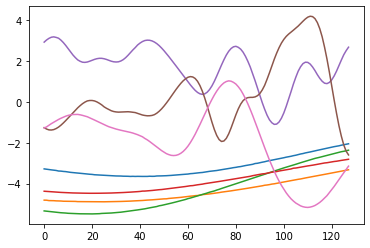

In [26]:
print(np.shape(means))
for i in range(num_fs):
    plt.plot(means[-1][i])
losses[losses!=losses] = 0

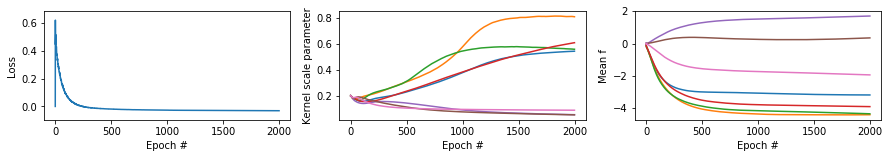

In [27]:
# prot loss function and kernel length
fig, (loss, kern, mean) = plt.subplots(1,3,figsize=(15,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
marg = (np.max(losses) - np.min(losses))*0.1
loss.set_ylim(np.min(losses)-marg,
              np.max(losses)+marg)
rbf=np.array(rbf).squeeze()
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
mean.plot([np.mean(x,axis=1) for x in means])
mean.set_xlabel("Epoch #")
mean.set_ylabel("Mean f")
fig.show()

In [28]:
# define test set (optionally on GPU)
denser = 1 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float().cuda(device=0)

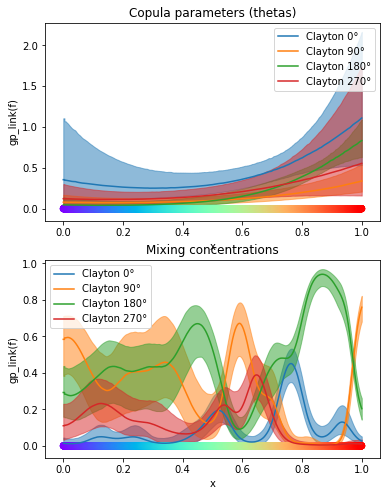

In [29]:
# visualize the result
fig, ax = plt.subplots(2,1,figsize=(6, 8))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function

thetas, mixes = gplink(output.mean)
lower, upper = output.confidence_region() #thetas & mix together
thetas_low, mixes_low = gplink(lower)
thetas_upp, mixes_upp = gplink(upper)

copulas = [lik.name for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]
 
for t,l,u,c,r in zip(thetas,thetas_low,thetas_upp,copulas,rotations):
    F_mean = t.detach().cpu().numpy()
    line, = ax[0].plot(testX, F_mean, label = '{} {}'.format(c,r))
    ax[0].fill_between(testX, l.detach().cpu().numpy(),
                    u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)
    
ax[0].scatter(np.linspace(0., 1., NSamp),np.zeros(NSamp),color=colors)
ax[0].set_xlabel('x')
ax[0].set_ylabel('gp_link(f)')
ax[0].set_title('Copula parameters (thetas)')
ax[0].legend()

_, sampled = gplink(output.rsample(torch.Size([100])))

for i, (t,c,r) in enumerate(zip(mixes[:],copulas,rotations)):
    F_mean = t.detach().cpu().numpy()
    line, = ax[1].plot(testX, F_mean, label = '{} {}'.format(c,r))
    sm = np.mean(sampled[i].cpu().numpy(),axis=0)
    std = np.std(sampled[i].cpu().numpy(),axis=0)
    ax[1].fill_between(testX, sm-std, sm+std, color=line.get_color(), alpha=0.5)
#     ax[0,1].fill_between(testX, l.detach().cpu().numpy(),
#                     u.detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

ax[1].scatter(np.linspace(0., 1., NSamp),np.zeros(NSamp),color=colors)
ax[1].set_xlabel('x')
ax[1].set_ylabel('gp_link(f)')
ax[1].set_title('Mixing concentrations')
ax[1].legend()

# # sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
# with gpytorch.settings.num_likelihood_samples(1):
#     Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()
# ax[1,0].scatter(*Y[::skip].T, label = 'True train data', color=colors[::skip])
# ax[1,1].scatter(*Y_sim[:,::skip].T, label = 'Sample from the model', color=colors[::skip])
# for c in [0,1]:
#     ax[1,c].set_xlabel('$y_1$')
#     ax[1,c].set_ylabel('$y_2$')
# ax[1,0].set_title('True data samples')
# ax[1,1].set_title('Samples from copula with theta=gplink(f(x))')
# samp.legend()



fig.show()

In [30]:
import gc
gc.collect()
torch.cuda.empty_cache() 

gplink = model.likelihood.gplink_function
copulas = [lik.copula for lik in likelihoods]
rotations = [lik.rotation for lik in likelihoods]

S=500
with torch.no_grad():
    f_samples = model(train_x).rsample(torch.Size([S]))
    thetas, mixes = gplink(f_samples)
    ###
#     samples = torch.empty_like(train_y).uniform_(1e-4, 1. - 1e-4)
#     null_log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
#             log_prob(samples).detach().cpu().numpy()
#     null_pwaic = np.var(null_log_prob,axis=0).sum()
#     print('Null AIC: ', (null_log_prob.sum()/N - null_pwaic))
    ###
    log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
            log_prob(train_y).detach().cpu().numpy()
    pwaic = np.var(log_prob,axis=0).sum()
    sum_prob = np.exp(log_prob).sum(axis=0)
    lpd=np.sum(np.log(sum_prob)-np.log(S)) # sum_M log(1/N * sum^i_S p(y|theta_i)), where N is train_x.shape[0]
    ###
#     with gpytorch.settings.num_likelihood_samples(1):
#          y_sim = model.likelihood(model(train_x)).rsample()
#     self_log_prob = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).\
#             log_prob(y_sim.squeeze()).detach().cpu().numpy()
#     self_pwaic = np.var(self_log_prob,axis=0).sum()
#     print('Self AIC: ', (self_log_prob.sum()/N - self_pwaic))
    ###
    #print('Log_probability: ',log_prob.sum())
    print('Lpd: ',lpd)
    print('p_WAIC: ',pwaic)
    print('WAIC: ', lpd - pwaic)

del(f_samples, log_prob)
torch.cuda.empty_cache() 
# model.likelihood.copula

Lpd:  285.75925
p_WAIC:  23.37881
WAIC:  262.38043


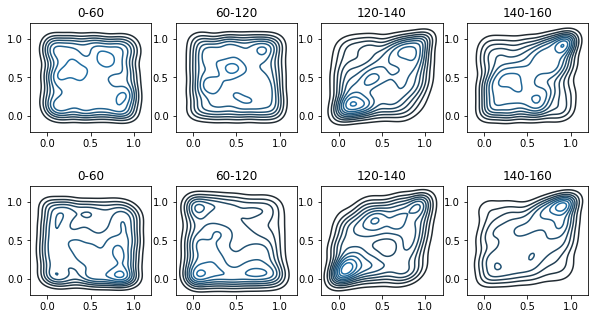

In [18]:
import seaborn as sns

with gpytorch.settings.num_likelihood_samples(1):
    gplink = model.likelihood.gplink_function
    copulas = [lik.copula for lik in likelihoods]
    rotations = [lik.rotation for lik in likelihoods]
    thetas, mixes = gplink(model(train_x).mean)
    Y_sim = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).rsample().cpu().detach().numpy()
    #Y_sim = model.likelihood(model(train_x)).rsample().cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(10,5))
fig.subplots_adjust(hspace=0.5)

X_pos = X.squeeze()*160
Y_pos = Y_sim.squeeze()

mrg = 0.2

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten(),['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=False,  shade_lowest=True)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))
    
X_pos = X.squeeze()*160
Y_pos = Y

mrg = 0.2

for s,e,ax,name in zip([0,60,120,140],[60,120,140,160],axes.flatten()[4:],['0-60','60-120','120-140','140-160']): #['0-1','1-2','2-3','3-4']
    sns.kdeplot(*Y_pos[(X_pos[:]>=s) & (X_pos[:]<e)].T, ax=ax, shade=False,  shade_lowest=True)
    ax.set(title=name, xlim=(-mrg,1+mrg), ylim=(-mrg,1+mrg))

In [19]:
# bins = 25

# N_rep = 50 # log_prob for stochastic parameters needs to be evaluated several times

# torch.cuda.empty_cache()

# p_den = torch.zeros([bins,bins,train_x.shape[0]])#.cuda()

# gplink = model.likelihood.gplink_function
# copulas = [lik.copula for lik in likelihoods]
# rotations = [lik.rotation for lik in likelihoods]

# with torch.no_grad():
#     for _ in range(N_rep):
#         torch.cuda.empty_cache()
#         f_samples = model(train_x).rsample(torch.Size([bins*bins]))
#         thetas, mixes = gplink(f_samples)
#         copula = model.likelihood.copula(thetas.cpu(),mixes.cpu(),copulas,rotations=rotations)

#         centre_bins = (np.mgrid[0:bins,0:bins]/bins + 1/2/bins).T
#         samples = centre_bins.reshape(-1,2)
#         samples = torch.tensor(samples).float()
#         size = torch.Size([train_x.shape[0]])+samples.shape
#         samples = samples.expand(size)
#         samples = torch.einsum('ijk->jik', samples)#.cuda()
#         p_pdf = torch.exp(copula.log_prob(samples))
#         p_den += p_pdf.reshape(bins,bins,train_x.shape[0])
    
# integral = p_den.sum((0,1))
# p_den = p_den/integral

In [20]:
# train_y_binarized = torch.zeros_like(p_den)
# train_y_binarized[(train_y[:,0]*bins).long(),(train_y[:,1]*bins).long()] = 1
# train_y_binarized = train_y_binarized.byte()
# p_den[train_y_binarized].log().sum()/train_x.shape[0]

In [21]:
# with gpytorch.settings.num_likelihood_samples(1):
#      y_sim = model.likelihood(model(train_x)).rsample()
# train_y_binarized = torch.zeros_like(p_den)
# train_y_binarized[(y_sim[:,0]*bins).long(),(y_sim[:,1]*bins).long()] = 1
# train_y_binarized = train_y_binarized.byte()
# p_den[train_y_binarized].log().sum()/train_x.shape[0]

In [22]:
# samples = torch.empty_like(train_y).uniform_(1e-4, 1. - 1e-4)
# train_y_binarized = torch.zeros_like(p_den)
# train_y_binarized[(samples[:,0]*bins).long(),(samples[:,1]*bins).long()] = 1
# train_y_binarized = train_y_binarized.byte()
# p_den[train_y_binarized].log().sum()/train_x.shape[0]